In [35]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [17]:
sequence_length = 4
batch_size = 1 #for parallel processing, default as 1
input_dim = 512
d_model = 512 #output of attention for every single word
x = torch.randn ( (batch_size, sequence_length, input_dim) )

In [18]:
x.size()

torch.Size([1, 4, 512])

In [19]:
qkv_layer = nn.Linear(input_dim , 3 * d_model) #qkv all concatenated

In [20]:
qkv = qkv_layer(x)

In [21]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

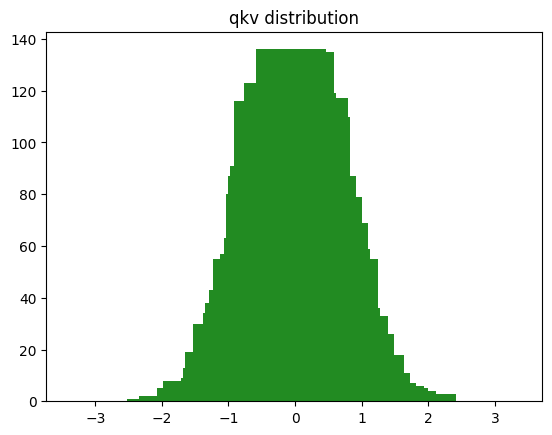

In [22]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [31]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)
qkv.shape


torch.Size([1, 4, 8, 192])

In [32]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [33]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

## Self Attention for multiple heads

In [47]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [48]:
scaled.size()

torch.Size([1, 8, 4, 4])

In [67]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask , diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [68]:
(scaled+mask)[0][0]

tensor([[-0.0291,    -inf,    -inf,    -inf],
        [ 0.0426,  1.0389,    -inf,    -inf],
        [ 0.0604, -0.1082,  0.3660,    -inf],
        [ 0.3695,  0.0682,  0.0839,  0.0161]], grad_fn=<SelectBackward0>)

In [76]:
attention = F.softmax(scaled, dim=-1)
attention[0][0] 

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.2697, 0.7303, 0.0000, 0.0000],
        [0.3123, 0.2638, 0.4239, 0.0000],
        [0.3131, 0.2316, 0.2353, 0.2199]], grad_fn=<SelectBackward0>)

In [78]:
values = torch.matmul(attention ,v)
values.shape

torch.Size([1, 8, 4, 64])

In [80]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [81]:
values ,attention =scaled_dot_product(q, k, v, mask=mask)

In [85]:
attention.shape

torch.Size([1, 8, 4, 4])

In [87]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.2697, 0.7303, 0.0000, 0.0000],
        [0.3123, 0.2638, 0.4239, 0.0000],
        [0.3131, 0.2316, 0.2353, 0.2199]], grad_fn=<SelectBackward0>)

In [89]:
values.size()

torch.Size([1, 8, 4, 64])

In [95]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [96]:
linear_layer = nn.Linear(d_model, d_model)

In [98]:
out = linear_layer(values)

In [99]:
out.shape

torch.Size([1, 4, 512])

## All Put Together

In [ ]:
def scaled_dot_product(q, k,, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention ,v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()